# **Hackaviz 2025** - DataSwag: the data exploration and processing notebook.

The Hackaviz challenge is a yearly, two weeks long data visualization competition organized by [Toulouse DataViz](https://toulouse-dataviz.fr/hackaviz/editions-precedentes/) where participants are encouraged to engage with real-world datasets and create **innovative** designs.<br>This is the backstage notebook of the analysis that helped me crack the dataset's 160+ years of continuous data. If you're curious about the end result you can have a look at it on the [DataSwag demo](https://brooks-code.github.io/miniature-fortnight) page.

![the flyer of the HackaViz 2025 challenge](img/dataviz_hackathon_hackaviz2025.png "Data visualization challenge") 

This year's [datasets](https://github.com/Toulouse-Dataviz/hackaviz-2025) aimed at paying a tribute to the 150th anniversary of the [flood of June 23, 1875](https://en.wikipedia.org/wiki/Garonne#Floods), which devastated numerous locations and left 200 dead and 25 000 homeless. In Toulouse, the flooding was particularly severe on the left bank of the Garonne (Saint-Cyprien and Croix de Pierre districts), but also on the right bank (Saint-Michel and les Amidonniers districts). This catastrophic event is at the origin of the **preventive measures deployed** since then: dykes, doors on the river banks, new building regulations and of course, the implementation of public policies for surveillance and safety.

**Table of contents**
- [**Hackaviz 2025** - DataSwag: the data exploration and processing notebook.](#hackaviz-2025---dataswag-the-data-exploration-and-processing-notebook)    
  - [Where we will explore the data](#where-we-will-explore-the-data)    
  - [Exploratory data analysis](#exploratory-data-analysis)    
    - [Overview statistics](#overview-statistics)    
    - [Frequency histograms](#frequency-histograms)    
    - [Missing data analysis](#missing-data-analysis)    
      - [Absence of a value in the recordings](#absence-of-a-value-in-the-recordings)    
      - [Missing periods](#missing-periods)    
    - [The flood dataset, a quick overview](#the-flood-dataset-a-quick-overview)    
        - [General observations](#general-observations)    
        - [Trends over time](#trends-over-time)    
    - [Detailed data distribution of the water-levels](#detailed-data-distribution-of-the-water-levels)    
    - [Outlier detection](#outlier-detection)    
  - [Having fun with Matplotlib: plotting and beyond](#having-fun-with-matplotlib-plotting-and-beyond)    
    - [You said joyplot?](#you-said-joyplot)    
      - [Classic: frequency distribution *(radio edit)*](#classic-frequency-distribution-radio-edit)    
      - [What's your ridge-limnigram flavor, monestre?](#whats-your-ridge-limnigram-flavor-monestre)    
    - [More plots](#more-plots)    
      - [Plots by year](#plots-by-year)    
      - [Animated yearly lineplots](#animated-yearly-lineplots)    
      - [Low-variability years](#low-variability-years)    
      - [Diverging years](#diverging-years)    
        - [minmax years](#minmax-years)    
        - [Most excessive year versus more consistent](#most-excessive-year-versus-more-consistent)    
    - [**Acknowledgements**](#acknowledgements) 

---

![the last of us part 1 menu screen](img/last_of_us_part1.jpg "part 1 header") 

## Where we will explore the data
♬ *A Fifth of Beethoven - Walter Murphy and the Big Apple Band (1976)*

Load libraries and helper functions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from hackaviz_helper import load_flood_dataset, plot_frequency_histogram, plot_missing_values, find_missing_periods, plot_distribution, detect_outliers

Datasets loading
>Datasets will be downloaded and the folder created if necessary.

In [3]:
# specify the folder path
dataset_folder = "dataset"

# datasets delimiters
FLOOD_DATA_DELIMITER = "crue"
FULL_DATASET_DELIMITER = "long"

Main dataset
>160+ years of continuous data.

In [4]:
historical_df, full_dataset_filepath = load_flood_dataset(
    dataset_folder, FULL_DATASET_DELIMITER)
historical_df.info()

Loaded: (1613286, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1613286 entries, 0 to 1613285
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype              
---  ------        --------------    -----              
 0   code_station  1613286 non-null  object             
 1   hauteur       1613286 non-null  float64            
 2   date_heure    1613286 non-null  datetime64[us, UTC]
dtypes: datetime64[us, UTC](1), float64(1), object(1)
memory usage: 36.9+ MB


Floods-only dataset
> We will use it only for some cross-checking.

In [5]:
flood_only_df,flood_filepath = load_flood_dataset(dataset_folder, FLOOD_DATA_DELIMITER)
flood_only_df.info()

Loaded: (128714, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128714 entries, 0 to 128713
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   code_station  128714 non-null  object             
 1   hauteur       128714 non-null  float64            
 2   date_heure    128714 non-null  datetime64[us, UTC]
 3   code_crue     128714 non-null  category           
dtypes: category(1), datetime64[us, UTC](1), float64(1), object(1)
memory usage: 3.1+ MB


## Exploratory data analysis

### Overview statistics

In [6]:
historical_df.describe()

,hauteur
count,1613286.00
mean,696.12
std,331.67
min,-800.00
25%,483.00
50%,620.00
75%,850.00
max,8320.00


>**Warning:** a max of 571000 is definately suspicious. More about the other values after the dataset cleaning.

In [7]:
print(f"Count of distinct values for {full_dataset_filepath}:")
historical_df.nunique()

Count of distinct values for dataset/hauteur_eau_serie_longue_toulouse.parquet:


code_station         3
hauteur           2654
date_heure      995649
dtype: int64

In [8]:
print(f"Count of duplicate values, for {full_dataset_filepath}, row wise:")
# only additional duplicates are counted (first occurrence is excluded).
print(historical_df.duplicated().sum())
# all occurrences of a duplicate row are counted
print(historical_df.duplicated(keep=False).sum())
# consider duplication based on the subset
# counts every row that shares the same "date_heure" value with another row.
print(historical_df.duplicated(subset=["date_heure"], keep=False).sum())

Count of duplicate values, for dataset/hauteur_eau_serie_longue_toulouse.parquet, row wise:
0
0
1235274


No duplicate rows. Just note this: we can have different recordings registered at the same time -but by different stations. Let's dig that a bit.

In [9]:
station_recording_range = historical_df.groupby("code_station")["date_heure"].agg(
    ["min", "max"]).rename(columns={"min": "first_recording", "max": "latest_recording"}).reset_index()
station_recording_range

,code_station,first_recording,latest_recording
0,O200004001,1946-01-04 11:00:00+00:00,2024-12-31 23:55:00+00:00
1,O200004002,1857-05-01 18:00:00+00:00,1945-12-31 12:00:00+00:00
2,O200008001,1990-10-13 17:00:00+00:00,2024-12-31 23:55:00+00:00


Okay, the recordings of these two stations (O200008001 and O200004001) overlap. It's not a big deal since for our use-case we will use daily max values.

### Frequency Histograms
First, let's visually check the frequencies distribution of the dataset, this will allow a quick identification of patterns and potential outliers within the data.

Univariate histograms for dataset/hauteur_eau_serie_longue_toulouse.parquet:


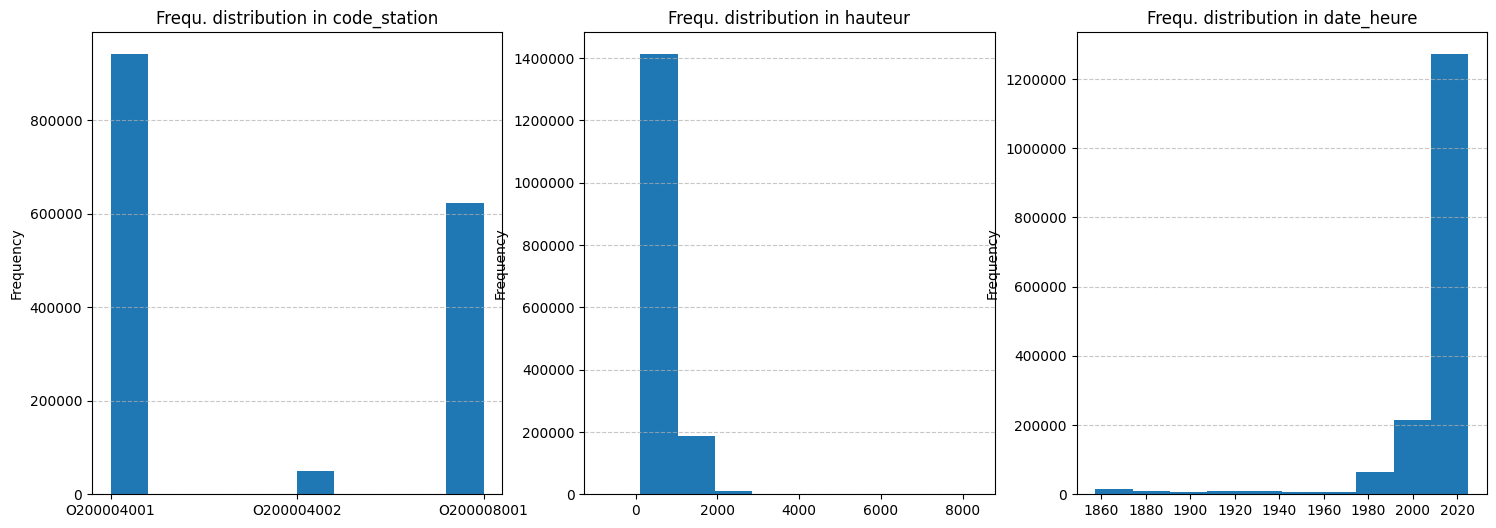

In [10]:
print(f"Univariate histograms for {full_dataset_filepath}:")
plot_frequency_histogram(historical_df)

Observations: 
<br>These three bar charts represent the different variable in the dataset.<br>

- The first chart deals with the recording stations. The variability in water-level recordings by stations is due to the fact that some stations were shutdown a long time ago and regarding the newest stations the recording frequency increased due to the automation of the recording process.
- Like seen in the `.describe` [above](#overview-statistics), the second histogram may indicate a dataset with some outliers within the water-level heights (hauteur) recordings. It suggests a highly skewed distribution of these values (*more on this a bit [later](#detailed-data-distribution-of-the-water-levels), in the distribution section*).
- The last barplot shows a drastic increase in values over time, this corroborate the fact that starting in the the 80s automation took-off. Therefore there is much more data available in the last two decades than a century ago when things were manual.


### Missing data analysis

#### Absence of a value in the recordings
Do we have recordings that have `null` values?

In [11]:
plot_missing_values(historical_df, full_dataset_filepath)

Missing data statistics for dataset/hauteur_eau_serie_longue_toulouse.parquet:
code_station    0
hauteur         0
date_heure      0
dtype: int64
Plot not necessary, no missing data found.


#### Missing periods
Gaps in time series data specifically refer to periods where data points are missing due to the absence of observations for certain time intervals. It's important to know if we have (significant) gaps between some records. Since the first recording, dating back to 1857 until the last record from dec. 2024, we should have at least one observation per day. 

In [12]:
historical_df

,code_station,hauteur,date_heure
0,O200004001,500.00,1946-01-04 11:00:00+00:00
1,O200004001,550.00,1946-01-05 11:00:00+00:00
2,O200004001,450.00,1946-01-06 11:00:00+00:00
3,O200004001,450.00,1946-01-07 11:00:00+00:00
4,O200004001,400.00,1946-01-08 11:00:00+00:00
...,...,...,...
1613281,O200008001,678.00,2024-12-31 23:35:00+00:00
1613282,O200008001,673.00,2024-12-31 23:40:00+00:00
1613283,O200008001,668.00,2024-12-31 23:45:00+00:00
1613284,O200008001,671.00,2024-12-31 23:50:00+00:00


In [13]:
missing_periods = find_missing_periods(historical_df, "date_heure")
print(missing_periods)

{'missing_years': ['1874', '2015'], 'missing_months': ['01-1862', '02-1862', '01-1874', '02-1874', '03-1874', '04-1874', '05-1874', '06-1874', '07-1874', '08-1874', '09-1874', '10-1874', '11-1874', '12-1874', '01-1919', '04-1919', '06-1919', '07-1919', '08-1919', '09-1919', '11-1919', '12-1919', '05-1924', '01-1987', '11-1997', '01-2015', '02-2015', '03-2015', '04-2015', '05-2015', '06-2015', '07-2015', '08-2015', '09-2015', '10-2015', '11-2015', '12-2015'], 'missing_days': ['1857-09-19', '1857-09-21', '1857-09-22', '1857-09-23', '1857-09-24', '1857-12-11', '1857-12-12', '1857-12-15', '1857-12-16', '1857-12-17', '1857-12-18', '1857-12-21', '1857-12-22', '1857-12-23', '1857-12-24', '1857-12-26', '1857-12-28', '1857-12-29', '1857-12-30', '1857-12-31', '1858-01-01', '1858-01-02', '1858-01-03', '1858-01-04', '1858-01-05', '1858-01-06', '1858-01-07', '1858-01-08', '1858-01-09', '1858-01-10', '1858-01-11', '1858-01-12', '1858-01-13', '1858-01-14', '1858-01-15', '1858-01-16', '1858-01-18', '1

>**To be considered:** the equivalent of *4+ years of data is missing*, with some years and months in full..

### The flood dataset, a quick overview

Let's gather some basic statistics.

In [14]:
flood_description = flood_only_df.groupby("code_crue", observed=False)[
    "hauteur"].describe()
flood_description

,count,mean,std,min,25%,50%,75%,max
code_crue,,,,,,,,
1857,129.00,1018.91,697.14,250.00,500.00,700.00,1500.00,2400.00
1875,394.00,2202.61,1907.68,650.00,882.50,1370.00,2760.00,8790.00
1879,71.00,1278.59,341.70,820.00,1050.00,1200.00,1355.00,2600.00
1900,110.00,2024.45,1013.17,850.00,1152.50,1470.00,2760.00,4000.00
1905,89.00,2097.75,1206.77,680.00,1020.00,1850.00,3250.00,4240.00
1952,100.00,2486.40,1487.89,650.00,1000.00,2225.00,4200.00,4570.00
1977,154.00,2388.44,937.19,860.00,1682.50,2305.00,2967.50,4310.00
2000,9503.00,773.00,830.18,-1530.00,440.00,740.00,1150.00,6490.00
2022,118164.00,802.59,864.91,-1476.00,265.00,740.00,1104.00,7458.00


##### General observations
*(water levels are in mm)*

* **Observations count**:
    the number of observations varies significantly across the years, with 2022 having an exceptionally high count (118164), while other years have counts ranging from 71 to 9503 records. This makes sense since 2022 has a more extensive data collection process with more frequent (automated) measurements.

* **Mean water-levels**:
    the mean water-levels show considerable variation, with the highest mean recorded in 1952 (2486.4) and the lowest in 2000 (773.0). The mean values indicate that, on average, flood water-levels have been following an increasing trend and been quite high until 1977, and steadily decreased since the 2000s to reach much lower levels. Has the nature of the floods changed over the years?

* **Standard deviation**:
    the standard deviation values indicate the variability (fluctuation) of water-levels within each year. For instance, 1879 has a low standard deviation (341.7), suggesting that the water-levels were relatively consistent, while years like 1875 and 1952 have much higher standard deviations (1907.7 and 1487.9, respectively), indicating more variability in water-levels.

* **Minimum and maximum values**:
    the minimum values for some years are negative (e.g., -1530.0 in 2000 and -1476.0 in 2022), these not errors but it means that the gauge is reading below the agreed-upon zero level.. The maximum values show an increasing trend of the maximas since the 2000s, but the extreme maximum recorded in 1875 (8790.0) stays unmatched.

* **Percentiles**:
    the 25th, 50th (median), and 75th percentiles provide insights into the distribution of water-levels. For example, the median water-level in 2022 is 740.0, which is lower than the mean, indicating a right-skewed distribution where a few high values are pulling the mean up.

##### Trends over time

1875 definately stands out as an exception.<br>
Overall, there appears to be an increasing trend in maximas over the years, but the variability has also decreased since 2000. I am really wondering if we're facing a **change of nature since the 2000s**? If so, is it because of new regulations across the Garonne and perhaps climate change is involved in this somehow as well? 


In [15]:
flood_date_range = flood_only_df.groupby("code_crue", observed=False)[
    "date_heure"].agg(["min", "max"])
flood_date_range

,min,max
code_crue,,
1857,1857-10-01 06:00:00+00:00,1857-10-31 18:00:00+00:00
1875,1875-06-01 00:00:00+00:00,1875-06-30 18:00:00+00:00
1879,1879-04-01 12:00:00+00:00,1879-04-30 18:00:00+00:00
1900,1900-05-15 06:00:00+00:00,1900-06-15 18:00:00+00:00
1905,1905-04-20 12:00:00+00:00,1905-05-20 18:00:00+00:00
1952,1952-01-15 05:00:00+00:00,1952-02-15 11:00:00+00:00
1977,1977-05-01 06:00:00+00:00,1977-05-31 06:00:00+00:00
2000,2000-06-01 00:00:00+00:00,2000-06-30 23:00:00+00:00
2022,2022-01-01 00:00:00+00:00,2022-01-31 23:55:00+00:00


We have one month of data for each flood.

In [16]:
# Extract the month portion from both columns and stack the results into one Series
combined_months = pd.concat(
    [flood_date_range["min"].dt.month_name(), flood_date_range["max"].dt.month_name()])

# Frequency counts of each month
month_counts = combined_months.value_counts()

two_most_frequent = month_counts.nlargest(2)
two_most_frequent

June    5
May     4
Name: count, dtype: int64

Most floods were recorded between June and May. This confirms the fact that in the Pyrenees region, flooding season is often springtime, during snowmelt period and is sometimes combined with rainfall. This type of flooding leads to fast paced water-level rising and is quite different from what can be seen in plains like Paris where the Seine water-level rises much slower.
In [Toulouse](https://inondations-agglo-toulousaine.fr/caracteristiques-historique-inondations/), the pace can reach as much as 50 cm/h.

### Detailed data distribution of the water-levels

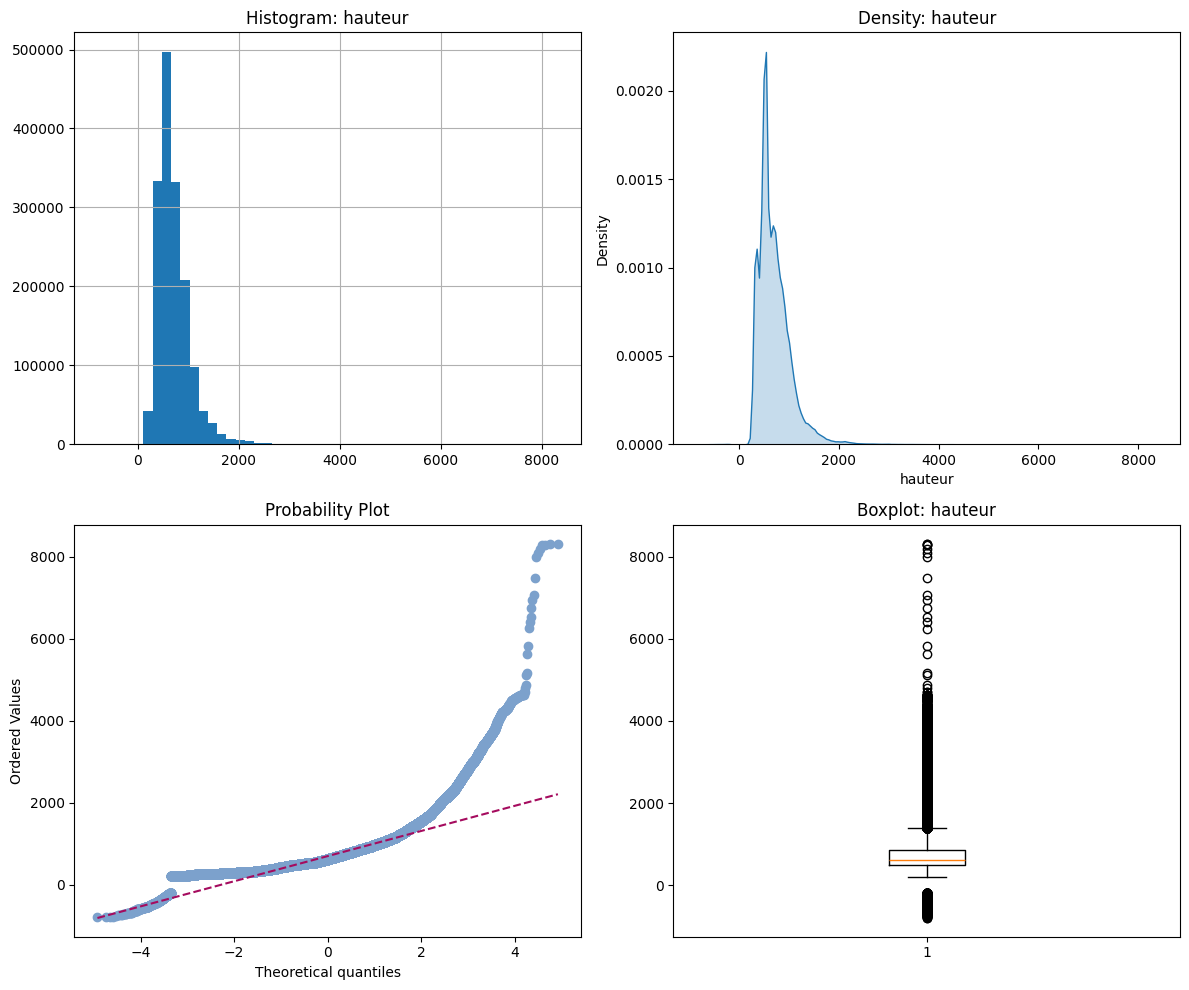

hauteur — mean: 696.1235682947723, med.: 620.0, mode: 520.0, std: 331.6654515517239, skew.: 2.15905202254332, kurt.: 10.899755145120757


In [17]:
plot_distribution(historical_df, grid=True)

These plots represent different statistical visualizations related to the "hauteur" variable (which translates to "height" in English and is expressed in *mm*).<br>
Let's skip the Histogram and density plot, they're hardly readable because of the skewness of the data points (We will study them [once](#outlier-detection) the dataset is cleaned).

The boxplot and probability plot are clearly suggesting the presence of outliers that are significantly higher values than the rest of the data.
The [kurtosis](https://www.statology.org/can-kurtosis-be-negative/) and [skewness](https://www.statology.org/left-skewed-vs-right-skewed/) value are confirming it:
- A positive skewness indicates that the tail on the right side of the distribution is longer or fatter than the left side, suggesting that there are a number of high values pulling the mean to the right. **A value of 517.21 is extremely high**, indicating a right-skewed distribution. This suggests that the majority of the data points are concentrated on the lower (left) end, with a few extremely high values creating a long tail on the right.
- A kurtosis value of 3 is considered normal (mesokurtic). Values greater than 3 indicate a distribution with heavier tails and a sharper peak (leptokurtic). A kurtosis value of **330707.69 is extraordinarily high**, suggesting that the distribution has extremely heavy tails and a very sharp peak.

Let's investigate a bit more those extreme values. For starters, we can filter out the obvious outliers (aberrations indicating hardly logical 300+ meter water-levels..)

In [18]:
historical_df[historical_df["hauteur"] > 300000]

,code_station,hauteur,date_heure


### Outlier detection
* We will use the Z-score. It is a statistical measure that indicates how many standard deviations a data point is from the mean.
* By manually tweaking the z-score threshold value we will filter out suspicious data points to our convenience.<br>
*(A nice + to have would be to automate it, since we have contextual historical data about the floods)*

In [19]:
z_score_outliers = detect_outliers(historical_df)
z_score_outliers

522 days containing 853 outliers


,code_station,hauteur,date_heure,date,n,mean,std,z_score
20725,O200004001,570.00,1983-10-31 23:00:00+00:00,1983-10-31,24,355.42,47.64,4.50
22131,O200004001,750.00,1983-12-31 23:00:00+00:00,1983-12-31,24,432.50,68.16,4.66
23101,O200004001,510.00,1984-02-15 15:00:00+00:00,1984-02-15,22,776.82,60.50,-4.41
25461,O200004001,480.00,1984-06-30 23:00:00+00:00,1984-06-30,24,818.33,72.27,-4.68
29521,O200004001,790.00,1984-12-31 23:00:00+00:00,1984-12-31,24,443.75,73.83,4.69
...,...,...,...,...,...,...,...,...
1585336,O200008001,424.00,2024-09-25 13:05:00+00:00,2024-09-25,286,292.15,31.09,4.24
1585337,O200008001,433.00,2024-09-25 13:10:00+00:00,2024-09-25,286,292.15,31.09,4.53
1585338,O200008001,430.00,2024-09-25 13:15:00+00:00,2024-09-25,286,292.15,31.09,4.43
1585339,O200008001,430.00,2024-09-25 13:20:00+00:00,2024-09-25,286,292.15,31.09,4.43


With the current setting, we've flagged 1050 records.<br>Buuut... We do not want a legitimate data point to be incorrectly classified as an outlier *(false positive)*. So let's make sure we don't flag data that actually belongs to one of the floods. High water-levels represent a significant event that are perfectly normal when there is a flood.

In [20]:
# Create an IntervalIndex representing each date range interval (with both endpoints included)
intervals = pd.IntervalIndex.from_arrays(
    flood_date_range["min"], flood_date_range["max"], closed="both")

# For each date in z_score_outliers, check if it falls within any of the intervals
mask = z_score_outliers["date_heure"].apply(
    lambda dt: intervals.contains(dt).any())

# Filter z_score_outliers to match rows within intervals
result = z_score_outliers[mask]
if result.empty:
    print("No false positive detected.\nThere are no z_score_outliers that fall within one of the flood date_range intervals.")
else:
    print("Rows from z_score_outliers that fall within one of the flood date_range intervals:")
    result

No false positive detected.
There are no z_score_outliers that fall within one of the flood date_range intervals.


Good, we can filter out these records safely.

In [21]:
df_filtered_outliers = historical_df[~historical_df.index.isin(
    z_score_outliers.index)]

In [22]:
df_filtered_outliers.describe()

,hauteur
count,1612433.00
mean,696.21
std,331.68
min,-800.00
25%,483.00
50%,620.00
75%,850.00
max,8320.00


In the cleaned dataset, we now have 1619504 records where the water height ranges from -800mm to 8320mm, with a mean of 694mm and most values between 481 and 850mm. To be sure the processing is accurate, we can check the maximum values of the cleaned dataset: they should match the historical records from 1875..

In [23]:
top8 = df_filtered_outliers.nlargest(8, "hauteur")
top8

,code_station,hauteur,date_heure
955415,O200004002,8320.00,1875-06-23 21:00:00+00:00
955416,O200004002,8320.00,1875-06-23 22:00:00+00:00
955417,O200004002,8290.00,1875-06-23 23:00:00+00:00
955414,O200004002,8280.00,1875-06-23 20:00:00+00:00
955413,O200004002,8190.00,1875-06-23 19:00:00+00:00
955412,O200004002,8080.00,1875-06-23 18:00:00+00:00
955411,O200004002,7990.00,1875-06-23 17:00:00+00:00
955410,O200004002,7470.00,1875-06-23 16:00:00+00:00


Bingo, we're good.. Now, let's check the distribution plots again, this time with the cleaned dataset.

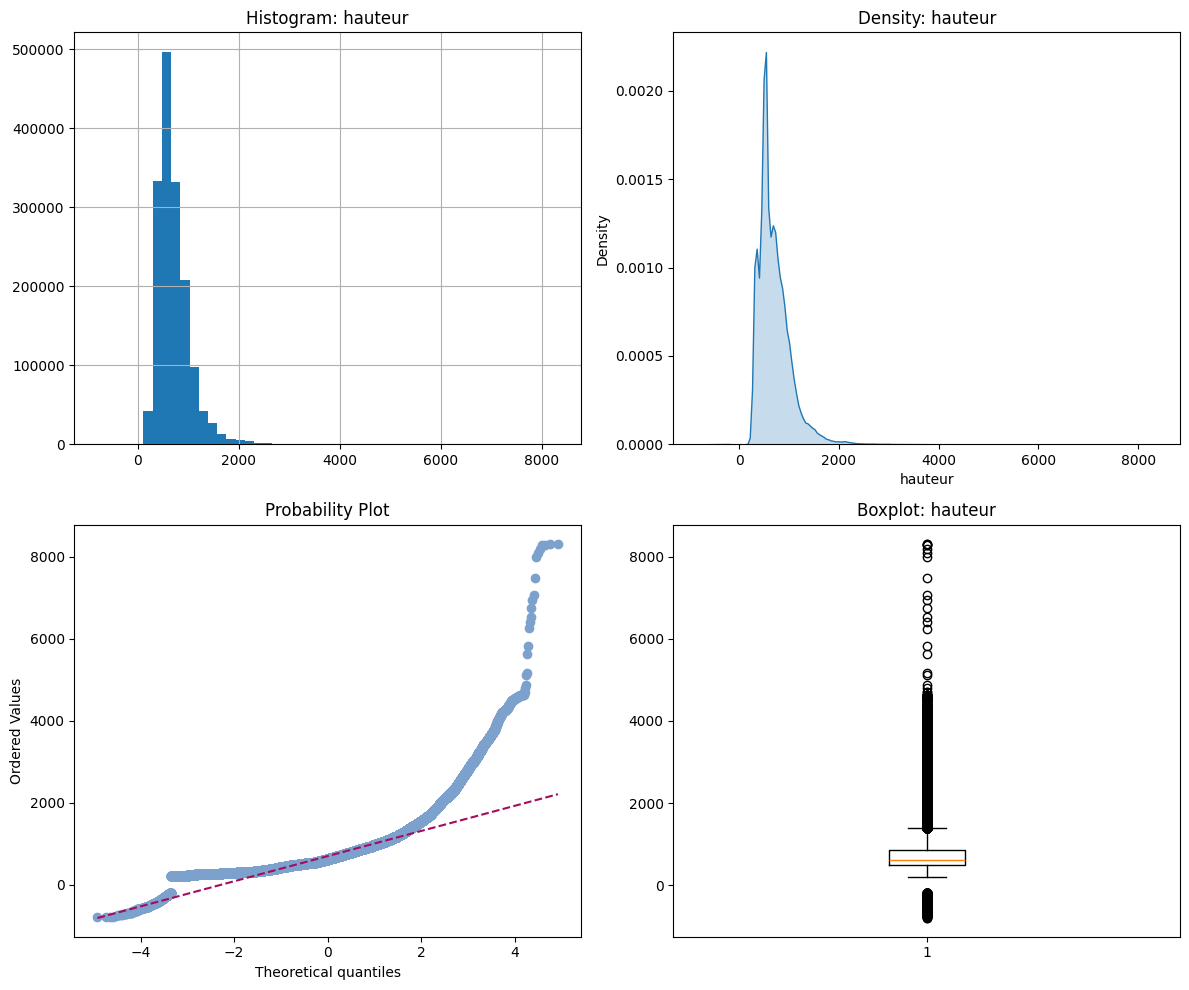

hauteur — mean: 696.2063254721281, med.: 620.0, mode: 520.0, std: 331.6821455256251, skew.: 2.1586334007326746, kurt.: 10.899024670804963


In [24]:
plot_distribution(df_filtered_outliers, full_dataset_filepath)

Much, better.

1. **Histogram**

    It displays the frequency distribution of the "hauteur" variable. The x-axis represents the height values, while the y-axis shows the number of occurrences (frequency) for each height range bin.<br>
    *Interpretation:* The histogram is right-skewed, indicating that most of the data points are concentrated at lower height values, with fewer observations at higher values. This suggests that the distribution is not normal and is influenced by contextual outliers (the floods).

2. **Density Plot**

    This is a smoothed version of the histogram, representing the probability density function of the "hauteur" variable.<br>
    *Interpretation:* Similar to the histogram, the density plot shows a right-skewed distribution. The peak of the density curve is located at lower height values, and it tapers off as height increases. This reinforces the observation from the histogram that the majority of the data is concentrated at lower values.

3. **Ordered Probability Plot**

    It compares the ordered values of the "hauteur" data against the quantiles of a theoretical normal distribution.<br>
    *Interpretation:* In such a plot, if the data points lie along the reference line (the jazzberry jam dashed line), it suggests that the data follows a normal distribution. In this case, the points deviate significantly from the line, especially at upper ends, indicating that the height does not follow a normal distribution.

4. **Boxplot**

    It provides a summary of the central tendency, variability, and also potential outliers in the "hauteur" data.<br>
    *Interpretation:* The [boxplot](https://www.simplypsychology.org/wp-content/uploads/boxplot.jpg) shows the median (the orange line inside the box), the interquartile range (IQR, represented by the box), and potential outliers (points outside the whiskers) who represent mostly the flood data. The boxplot also indicates that the median is closer to the lower quartile, which aligns with the right-skewed nature of the distribution.

**Conclusion**

Overall, these plots collectively indicate that the "hauteur" variable is right-skewed, with a concentration of values at lower heights and the presence of outliers. If we were to use some traditional statistical methods assuming normality. Transformations or non-parametric methods should be then needed for a further analysis.

---

![the last of us part II menu screen](img/last_of_us_part2.jpg "part 2 header") 


## Having fun with Matplotlib: plotting and beyond
♫ *Gustavo Santaolalla - The Last of Us (2013)*

In [25]:
from hackaviz_helper import prepare_data, plot_original_joyplot, plot_byflavor, plot_years, animate_years, plot_stable_years, plot_diverging_years, STYLES

### You said joyplot?

A Joyplot, also known as a ridgeline plot is a type of data visualization that displays the distribution of a variable over time or across different categories. Multiple density plots or histograms are stacked vertically, with each row representing a different time period or category. The overlaid plots are creating a sense of depth and allow the viewer to see how the distribution changes.<br> The name [Joyplot](https://en.wikipedia.org/wiki/Ridgeline_plot) is derived from the use of a ridgeline plot of the intensity of pulses from a pulsar on the front of Joy Division's album [Unknown Pleasures](https://en.wikipedia.org/wiki/Unknown_Pleasures).

![original joyplot](img/joyplot_unknown_pleasures.jpg "unknown pleasures vinyl") 

#### Classic: frequency distribution *(radio edit)*

Joyplot style ofc! As a *warmup* le't try to replicate the design with our data. We basically make a tailored use of the [joypy package](https://leotac.github.io/posts/2017/08/01/joypy/).

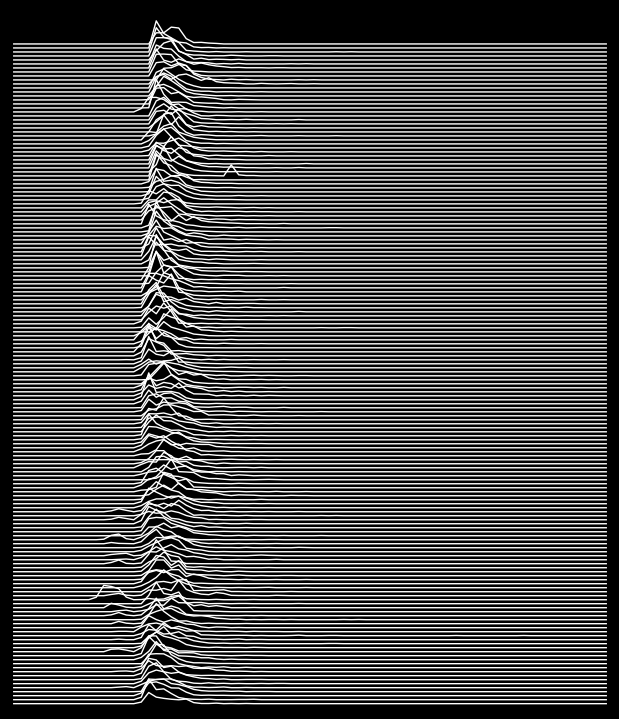

In [26]:
plot_original_joyplot(df_filtered_outliers)

Cute, no? This is a ridgeline plot of the daily‐maximum heights **counts** with uniform x-limits across all years. The ridges are stacked from 1857 to the bottom up to 2024 to the top.  The range of heights is divided into 80 equally‐sized intervals (bins). Stacked together the ridges show how the empirical distribution of daily maxima changes from year to year..

>**PS:** For readability, if you want to display the x-axis labels..<br> 
>In the helper function (located in `hackaviz_helper.py`):<br> 
>`def plot_original_joyplot(df: pd.DataFrame) -> None:`<br> 
>`"""Plot classic joyplot of daily-max heights by year."""`<br>
> → go to the `joyplot()` subfunction parameters and set `xlabels=False` to `True`.

#### What's your ridge-limnigram flavor, monestre?
Where we focus on daily maxima

Prepare the data once (and for all).

In [27]:
data_by_year, labels, daily = prepare_data(
    df_filtered_outliers, "date_heure", "hauteur")

>Now the *plat de résistance*. I can't recall exactly how that idea occured but I remember I thought about tree rings at some point. Do you know [dendrochronology](https://upload.wikimedia.org/wikipedia/commons/b/b2/Tree_cookie_in_Royal_Ontario_Museum_2023a.jpg)? It's like time traveling where thanks to tree rings you can catch many curiosities like ancient events but also climatological episodes, like a dry season or so.<br>

So here we go, we will get a ridgeline plot of daily maximum water‐heights, one line per year (newest at the top), declined in flavors that are highlighting some aspects of the dataset. For example *'calm'* is emphasizing the years with less fluctuations in distinct colors (darker is more stable in this case).
<br>Many flavors are on the menu. *Pick yours*.

<br> **N.B**: You might see some gaps on some lines: this relates to missing time periods (as seen [above!](#missing-periods)).

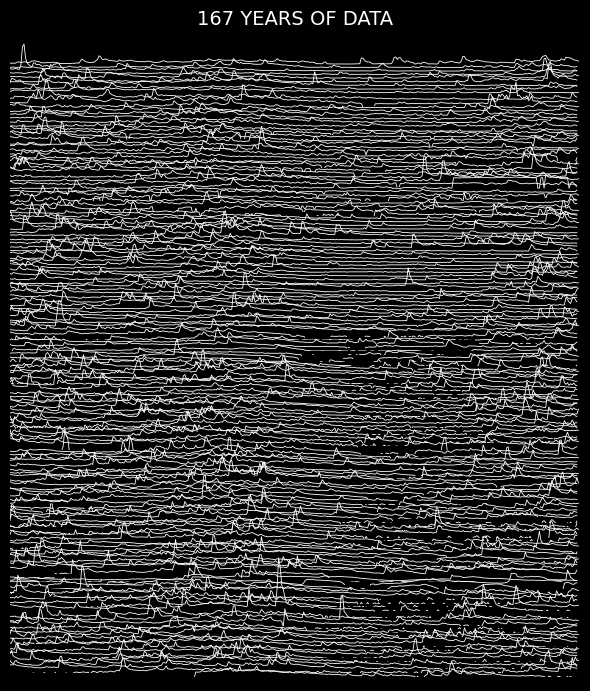

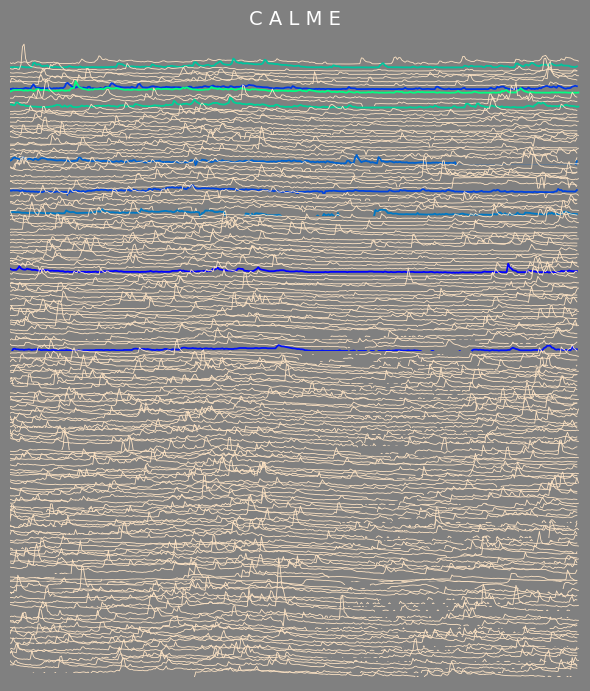

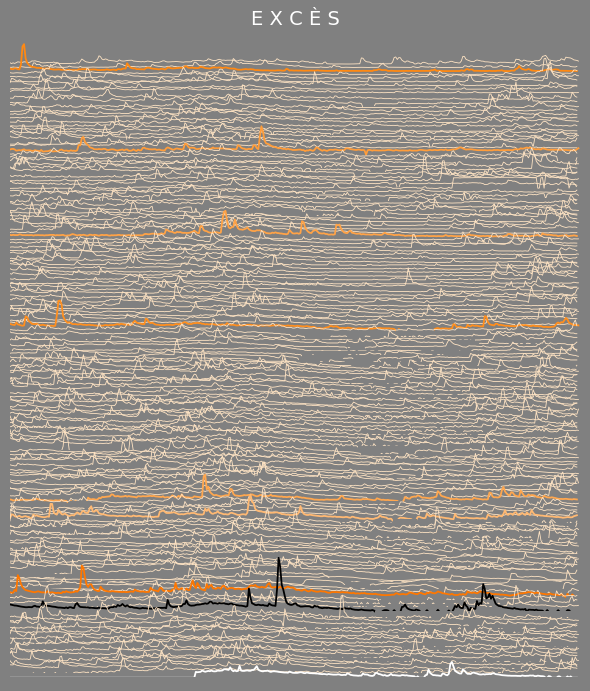

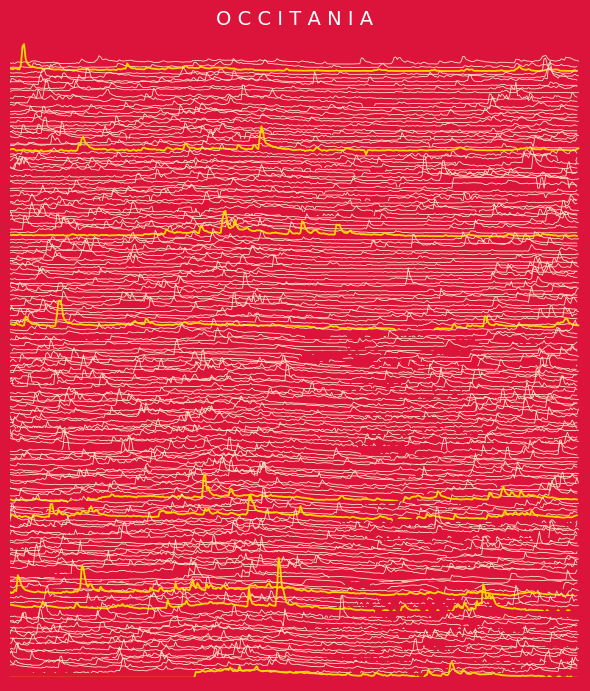

In [28]:
# a) Choose your style.. "classic", "calm", "excess" or "occitania"
# plot_flavor(data_by_year.copy(), labels, daily, style_key='classic')

# b) ..or display them all
for key in STYLES:
    plot_byflavor(data_by_year.copy(), labels, daily, style_key=key)

### More plots

**Note:** Regarding the following plots, data point between missing are interpolated in order to appear connected. In the `plot_years` and `plot_diverging_years` functions, this can be adjusted.

In [29]:
# From now, dark mode.
plt.style.use("dark_background")

#### Plots by year

This is tinkered as a quick toolbox for when you're curious about specific years.

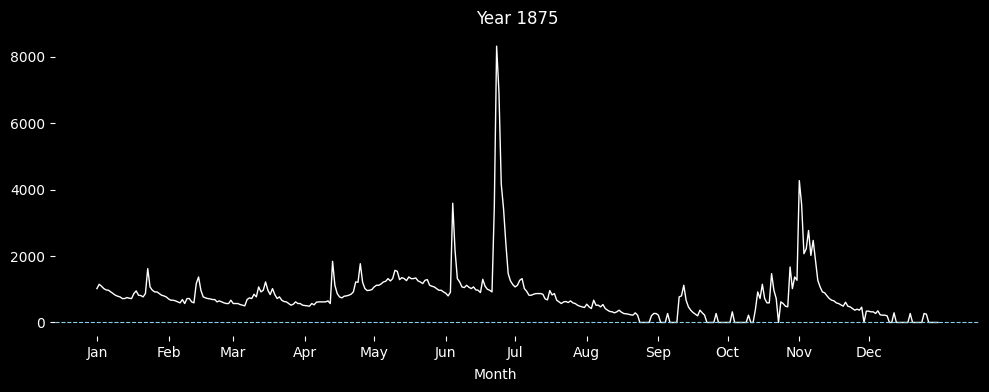

In [41]:
# plot a single year, a range(xxxx, xxxx), or an arbitrary list [xxxx, xxxx, xxxx]
plot_years(data_by_year, labels, 1875)

#### Animated yearly lineplots

This one is designed for the *cinema mode* of the [demo](https://brooks-code.github.io/miniature-fortnight). It will *animate* a line plot of the water-levels where each frame represents one year.

In [31]:
animate_years(
    data_by_year,
    labels,
    interval_ms=500,
    output="yearly_animation.gif",
    interpolate_gaps=False,
    truncated=True)

Saved animation to yearly_animation.gif


#### Low-variability years

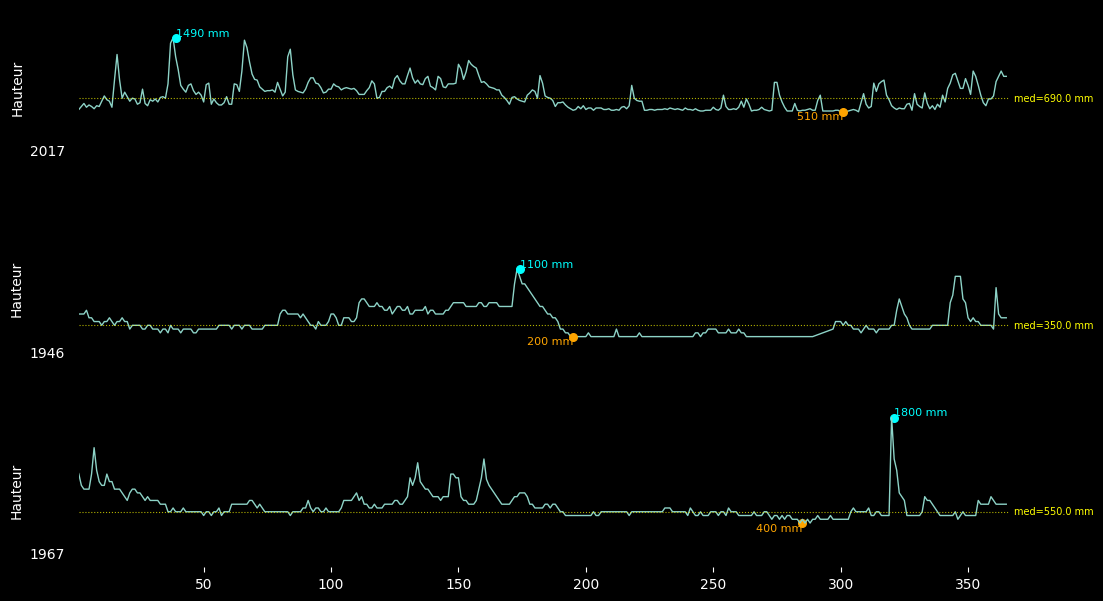

In [50]:
plot_stable_years(data_by_year, labels, interpolate_gaps=True, n_years=3)

#### Diverging years

##### minmax years

In [33]:
df_filtered_outliers.nsmallest(4, "hauteur")

,code_station,hauteur,date_heure
959676,O200004002,-800.00,1884-02-19 12:00:00+00:00
959718,O200004002,-800.00,1884-04-04 12:00:00+00:00
959675,O200004002,-780.00,1884-02-18 12:00:00+00:00
959719,O200004002,-780.00,1884-04-05 12:00:00+00:00


In [34]:
df_filtered_outliers.nlargest(4, "hauteur")

,code_station,hauteur,date_heure
955415,O200004002,8320.00,1875-06-23 21:00:00+00:00
955416,O200004002,8320.00,1875-06-23 22:00:00+00:00
955417,O200004002,8290.00,1875-06-23 23:00:00+00:00
955414,O200004002,8280.00,1875-06-23 20:00:00+00:00


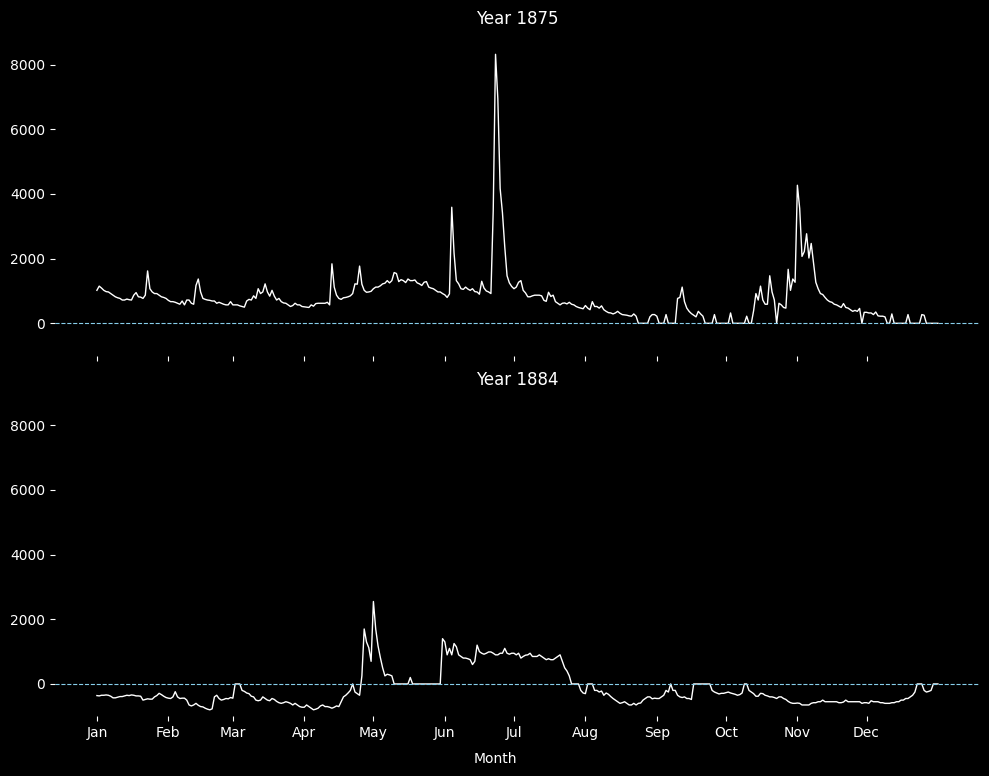

In [52]:
plot_diverging_years(
    data_by_year, labels,
    years=[1875, 1884], interpolate_gaps=True)

##### Most excessive year versus more consistent

In [59]:
df2 = df_filtered_outliers.copy()
df2["date_heure"] = pd.to_datetime(df2["date_heure"])
df2["Year"] = df2["date_heure"].dt.year
df2["Day"] = df2["date_heure"].dt.dayofyear

year_std = df2.groupby("Year")["hauteur"].std()

print(f"Years with low variability: {year_std.nsmallest(3).index.tolist()}")
print(f"Years with high variability: {year_std.nlargest(3).index.tolist()}")

Years with low variability: [2017, 1989, 1967]
Years with high variability: [1875, 1952, 1977]


**Todo:** investigate why steady years are not not showing in the same order as in plot_stable_years():
- hints
 1) plot_stable_years | Input data: a year_x_day_data 2D array and a np.nanstd() calculation [daily max values are aggregated by prepare_data(), missing days sentinels are replaced by nan and ddof is set to 0]
 2) above | Input data: df_filtered_outliers and a .std() calculation [no daily max values aggregation, no missing days handling]

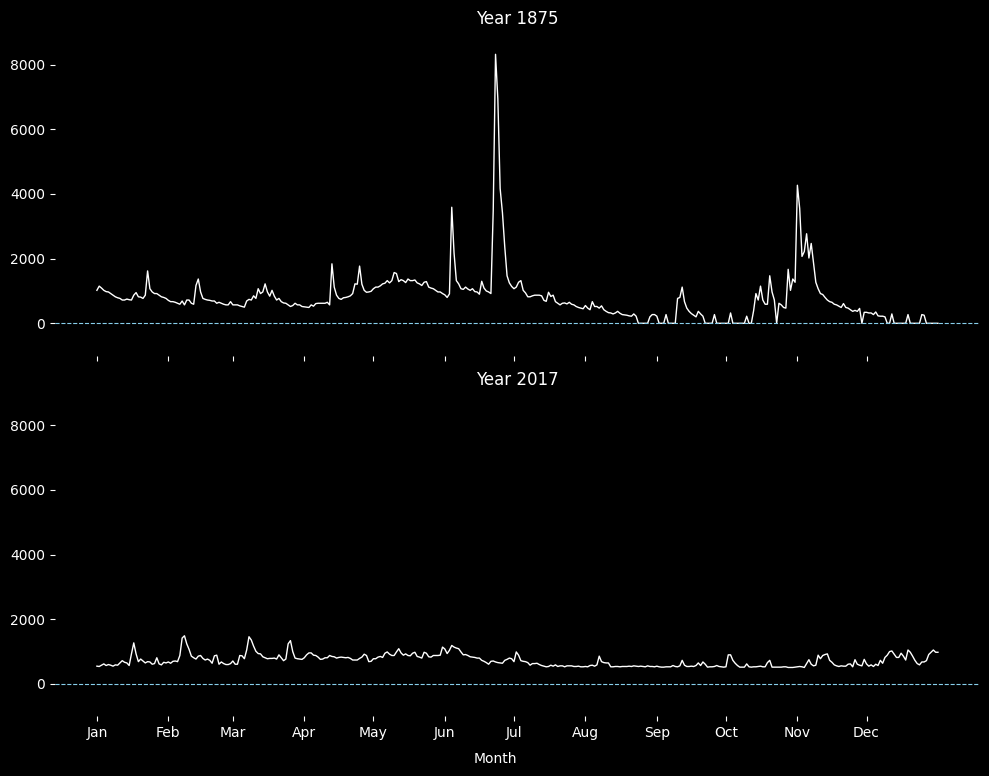

In [37]:
plot_diverging_years(
    data_by_year, labels,
    years=[1875, 2017])

That's all folks.

### **Acknowledgements**

The toulouse dataviz [team](https://toulouse-dataviz.fr/association/).<br>
The [joypy](https://pypi.org/project/joypy/) library authors.<br>
All the open source libraries used.. Thank you all.

*(2025) Notebook provided by [♣](github.com/brooks-code) under an [MIT license](https://mit-license.org/).*